In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist
import matplotlib.pyplot as plt

## Load Dataset and Preprocess

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [3]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Reshape to match the input shape of the CNN (batch size, height, width, channels)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

## Building CNN Model

In [4]:
print(f'Training Target: {y_train.shape}')
print(f'Testing Target: {y_test.shape}')

Training Target: (60000, 10)
Testing Target: (10000, 10)


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8547 - loss: 0.4847 - val_accuracy: 0.9814 - val_loss: 0.0580
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9813 - loss: 0.0600 - val_accuracy: 0.9862 - val_loss: 0.0429
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9877 - loss: 0.0394 - val_accuracy: 0.9849 - val_loss: 0.0450
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9910 - loss: 0.0281 - val_accuracy: 0.9881 - val_loss: 0.0341
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.9903 - val_loss: 0.0301


### Prediction of original CNN model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


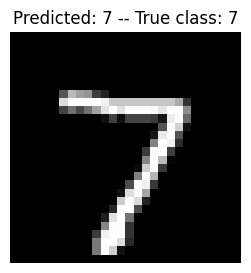

In [44]:
# Select a sample index from the validation set
sample_index = 0
sample_image = x_test[sample_index]
sample_label = y_test[sample_index]

# Expand dimensions to match the input shape expected by the model
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Image prediction
preds = model.predict(sample_image_expanded)
pred_class = np.argmax(preds, axis=1)
true_class = np.argmax(sample_label)

# Display the image with prediction
plt.figure(figsize=(5, 3))
plt.imshow(sample_image.squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title(f"Predicted: {pred_class[0]} -- True class: {true_class}")
plt.axis('off')
plt.show()

# Create an ART classifier

In [15]:
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(min_pixel_value, max_pixel_value),
)

In [16]:
# Create Evasion(FGSM) attack
epsilon = 0.1
attack = FastGradientMethod(estimator=classifier, eps=epsilon)

In [17]:
# Create second attack with 0.2 epsilon (stronger perturbation)
epsilon2 = 0.2
attack2 = FastGradientMethod(estimator=classifier, eps=epsilon2)

In [26]:
# Create third attack with 0.3 epsilon (stronger perturbation)
epsilon3 = 0.3
attack3 = FastGradientMethod(estimator=classifier, eps=epsilon3)

## Generate Adversarial Data and Accuracy

In [31]:
x_test_adv = attack.generate(x=x_test)

# Evaluate our classifier on the new adversarial data
adv_preds = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(adv_preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 1: {accuracy * 100:.2f}%')

Accuracy on adversarial test data 1: 88.19%


In [20]:
x_test_adv2 = attack2.generate(x=x_test)

adv_preds2 = classifier.predict(x_test_adv2)
accuracy2 = np.sum(np.argmax(adv_preds2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 2: {accuracy2 * 100:.2f}%')

Accuracy on adversarial test data 2: 45.40%


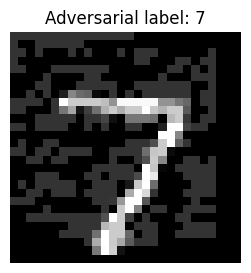

In [33]:
idx_adv2 = 0

plt.figure(figsize=(5, 3))
plt.imshow(x_test_adv2[idx_adv2].squeeze(), cmap='gray')
plt.title(f"Adversarial label: {np.argmax(adv_preds2[idx_adv2])}")
plt.axis('off')
plt.show()

In [27]:
x_test_adv3 = attack3.generate(x=x_test)

adv_preds3 = classifier.predict(x_test_adv3)
accuracy3 = np.sum(np.argmax(adv_preds3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 3: {accuracy3 * 100:.2f}%')

Accuracy on adversarial test data 3: 11.17%


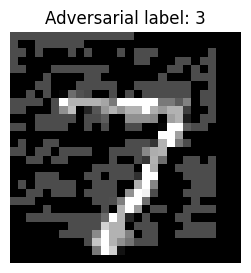

In [34]:
idx_adv3 = 0

plt.figure(figsize=(5, 3))
plt.imshow(x_test_adv3[idx_adv3].squeeze(), cmap='gray')
plt.title(f"Adversarial label: {np.argmax(adv_preds3[idx_adv3])}")
plt.axis('off')
plt.show()

# Plot all predictions and attacks

In [35]:
# Evaluate the model on the original test set
predictions_original = classifier.predict(x_test)
accuracy_original = np.sum(np.argmax(predictions_original, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on original test examples: {accuracy_original * 100:.2f}%")

Accuracy on original test examples: 99.03%


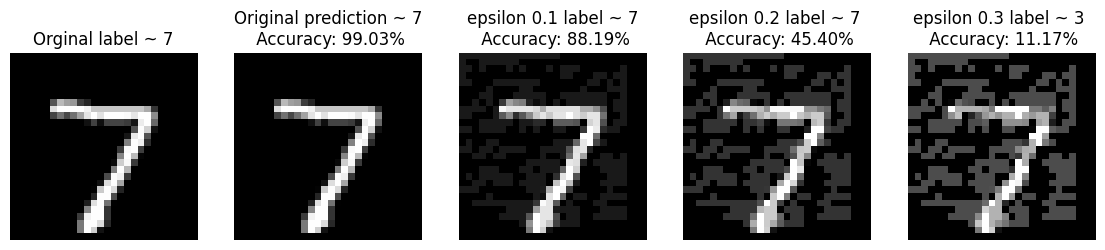

In [43]:
index_img = 0

plt.figure(figsize=(14, 7))

# Plot orginal image
plt.subplot(1, 5, 1)
plt.imshow(x_test[index_img].squeeze(), cmap='gray')
plt.title(f'Orginal label ~ {np.argmax(y_test[index_img])}')
plt.axis('off')

# Plot original prediction
plt.subplot(1, 5, 2)
plt.imshow(x_test[index_img].squeeze(), cmap='gray')
plt.title(f'Original prediction ~ {pred_class[0]}\n Accuracy: {accuracy_original * 100:.2f}%')
plt.axis('off')

# Plot adversarial image 1
plt.subplot(1, 5, 3)
plt.imshow(x_test_adv[index_img].squeeze(), cmap='gray')
plt.title(f"epsilon 0.1 label ~ {np.argmax(adv_preds[index_img])}\n Accuracy: {accuracy * 100:.2f}%")
plt.axis('off')

# Plot adversarial image 2
plt.subplot(1, 5, 4)
plt.imshow(x_test_adv2[index_img].squeeze(), cmap='gray')
plt.title(f"epsilon 0.2 label ~ {np.argmax(adv_preds2[index_img])} \n Accuracy: {accuracy2 * 100:.2f}%")
plt.axis('off')

# Plot adversarial image 3
plt.subplot(1, 5, 5)
plt.imshow(x_test_adv3[index_img].squeeze(), cmap='gray')
plt.title(f"epsilon 0.3 label ~ {np.argmax(adv_preds3[index_img])} \n Accuracy: {accuracy3 * 100:.2f}%")
plt.axis('off')

plt.show()